In [1]:
import pandas as pd

import src.data_extraction.filter_adult_patients as fap
import src.data_extraction.filter_ventilation_events as fve
from src.utils import utils

In [ ]:
admissions = pd.read_csv('./origin_data/admissions.csv',parse_dates=['admittime','dischtime','deathtime'])
intubation_all =  pd.read_csv('./origin_data/intubation_all.csv')
extubation_all =  pd.read_csv('./origin_data/extubation_all.csv')

In [3]:
intubation_data = fve.filter_and_label_ventilation_data(intubation_all, 'intubationtime', 'intubation')
extubation_data = fve.filter_and_label_ventilation_data(extubation_all, 'extubationtime', 'extubation')

In [4]:
def merge_dataframes(intubation_all, extubation_all, how='outer'):
    
    # 병합 수행
    merged_df = pd.merge(intubation_all, extubation_all, how=how, on=['subject_id','hadm_id'])
    
    return merged_df

merged_outer = merge_dataframes(intubation_data, extubation_data, how='outer')

In [5]:
merged_outer.rename(columns={
        'stay_id_x': 'int_stayid',
        'stay_id_y': 'ext_stayid',
        'itemid_x': 'int_itemid', 
        'patientweight_x': 'int_weight', 
        'itemid_y': 'ext_itemid', 
        'patientweight_y': 'ext_weight'
    }, inplace=True)   

In [6]:
intubation_extubation_merge = fve.join_admissions(merged_outer, admissions)

In [ ]:
# int_stayid를 기준으로 stay_id를 생성하는 함수
def create_int_stay_id(df):
    """
    'int_stayid' 기준으로 'stay_id' 칼럼 생성. 'int_stayid'가 NULL일 경우 'ext_stayid' 사용
    """

    df['stay_id'] = df.apply(
        lambda row: int(row['int_stayid']) if pd.notnull(row['int_stayid']) else int(row['ext_stayid']),
        axis=1
    )
    
    # 'stay_id' 칼럼 위치 변경
    column_order = ['subject_id', 'hadm_id', 'stay_id'] + [col for col in df.columns if col not in ['subject_id', 'hadm_id', 'stay_id']]
    df = df[column_order]
    
    return df

In [8]:
intubation_extubation_merge = create_int_stay_id(intubation_extubation_merge)

In [10]:
intubation_extubation_merge.to_csv('./data/intubation_extubation_merge_results.csv', index=True)

### 1. 재배열
- 1-1. intubationtime, intubationtime(un), extubationtime, extubationtime(un)이 포함된 테이블 읽기
- 1-2. intubation-extubation 은 pairing 되어야 하므로 연속해서 intubation event가 있거나 연속해서 extubation event 가 있으면 에러로 볼 수 있음.
- 1-3. error 타입 정의하고 해결
- 1-4. pairing 및 seq 부여

#### 1-1. intubationtime, intubationtime_un, extubationtime, extubationtime_un 이 포함된 테이블 읽기

<Figure size 2000x1000 with 0 Axes>

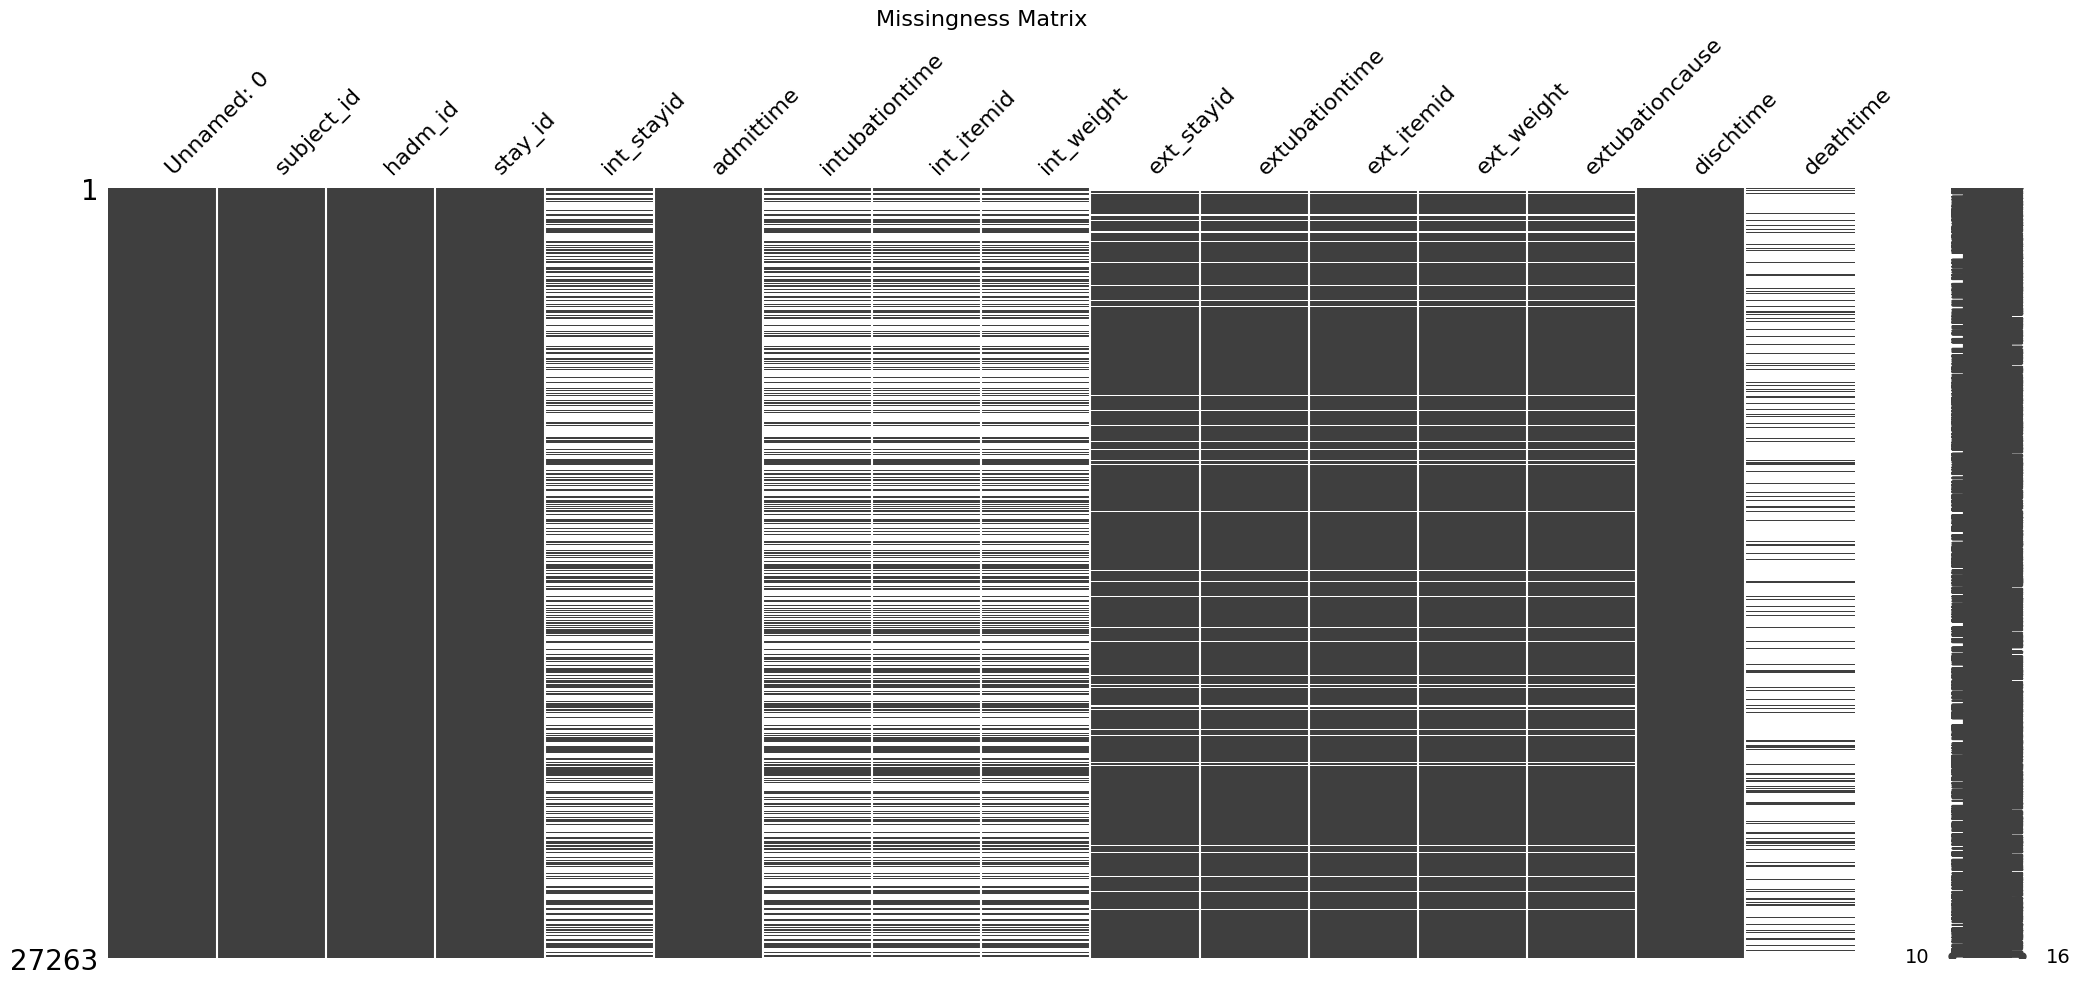

In [11]:
import missingno as msno
import matplotlib.pyplot as plt
import pandas as pd
from dfply import *
import time
from tqdm import tqdm
import warnings

before_withflag = pd.read_csv('./data/intubation_extubation_merge_results.csv', parse_dates=['admittime','intubationtime','extubationtime',\
                                    'dischtime','deathtime'])

# 결측치 행렬 생성
plt.figure(figsize=(20, 10))
msno.matrix(before_withflag)
plt.title('Missingness Matrix', fontsize=16)
plt.show()

#### 1-2. intubation-extubation 은 pairing 되어야 하므로 연속해서 intubation event가 있거나 연속해서 extubation event 가 있으면 에러로 볼 수 있음.


In [12]:
import src_unable as pairing   # 삽관 발관 페어링 관련 모듈
from src_unable import reintubation as rnt   # 재삽관 시간 계산 관련 모듈
from src_unable import align
from src_unable import subject_classification as cls
from src.utils import utils

In [13]:
before_withflag.info() # (27263, 16)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27263 entries, 0 to 27262
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Unnamed: 0       27263 non-null  int64         
 1   subject_id       27263 non-null  int64         
 2   hadm_id          27263 non-null  int64         
 3   stay_id          27263 non-null  int64         
 4   int_stayid       11528 non-null  float64       
 5   admittime        27263 non-null  datetime64[ns]
 6   intubationtime   11528 non-null  datetime64[ns]
 7   int_itemid       11528 non-null  float64       
 8   int_weight       11528 non-null  float64       
 9   ext_stayid       25676 non-null  float64       
 10  extubationtime   25676 non-null  datetime64[ns]
 11  ext_itemid       25676 non-null  float64       
 12  ext_weight       25676 non-null  float64       
 13  extubationcause  25676 non-null  object        
 14  dischtime        27263 non-null  datet

In [14]:
def intuextu_align(before_reconstruction):

    intubation_df = before_reconstruction[['subject_id','hadm_id','stay_id','intubationtime']]
    extubation_df = before_reconstruction[['subject_id','hadm_id','stay_id','extubationtime','extubationcause']]

    # 원본 데이터
    intubation_df['data_type']='real'
    extubation_df['data_type']='real'
    
    real_intu = intubation_df[['subject_id','hadm_id','stay_id','intubationtime','data_type']]
    real_intu.loc[:,'event_type'] = 'intubation'  # 삽/발관 표시
    real_intu.rename(columns={'intubationtime': 'time'}, inplace=True)

    real_extu = extubation_df[['subject_id','hadm_id','stay_id','extubationtime','data_type','extubationcause']]
    real_extu.loc[:,'event_type'] = 'extubation'
    real_extu.rename(columns={'extubationtime': 'time'}, inplace=True)

    table = pd.concat([real_intu, real_extu])
    table = table.dropna(subset = ['time'])

    table = table.sort_values(by=['subject_id','hadm_id','stay_id','time']).reset_index(drop = True)

    return table

In [15]:
# before_withflag, unable_intu_extu를 조합하여 table을 만듦. table_for_dup = pd.concat([table, icu_data])과 같이 최종테이블에 들어가게 됨
# 추후 icu_data를 쓰게 되는 이유는 unable intu/extu로도 페어링할 수 없을 때 icu_data의 intime과 outtime을 참고하여 페어링함
table = intuextu_align(before_withflag) # 원본에 기록되어있는 intuextu 페어링 | 시간 비교에 필요한 컬럼 추가

# 중복 제거, subject_id, hadm_id, stay_id, time, event_type이 모두 동일한 행 제거
table.sort_values(by=['subject_id','hadm_id','stay_id','time','data_type'], inplace = True)
table = table.drop_duplicates(subset=['subject_id', 'hadm_id', 'stay_id', 'time', 'event_type'], keep='first').reset_index(drop=True)

table = align.sort_intuextu(table) # 정렬 (삽/발관 시간이 같은 경우 intubation이 먼저 나옴)
table = align.duplicates_row_flag(table) # 연속해서 intubation이 있거나 extubation이 연속해서 있는 경우 flag_dup 생성
table = align.time_diff(table) # flag_dup인 행과 그 다음 행의 시간 차이 계산

C:\Users\inhae\AppData\Local\Temp\ipykernel_8740\1400658047.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intubation_df['data_type']='real'
C:\Users\inhae\AppData\Local\Temp\ipykernel_8740\1400658047.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extubation_df['data_type']='real'
C:\Users\inhae\AppData\Local\Temp\ipykernel_8740\1400658047.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

#### 1-3. error 타입 정의하고 해결


In [ ]:
print(f'intubation or extubation 중복인 경우: {round(table[table.flag_dup].shape[0] / table.shape[0] * 100, 2)}%')
print()
print(table.info()) # (31997, 9)
table

intubation or extubation 중복인 경우: 4.7%

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31997 entries, 0 to 31996
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   subject_id       31997 non-null  int64         
 1   hadm_id          31997 non-null  int64         
 2   stay_id          31997 non-null  int64         
 3   time             31997 non-null  datetime64[ns]
 4   data_type        31997 non-null  object        
 5   event_type       31997 non-null  object        
 6   extubationcause  23552 non-null  object        
 7   flag_dup         31997 non-null  bool          
 8   time_diff        1503 non-null   object        
dtypes: bool(1), datetime64[ns](1), int64(3), object(4)
memory usage: 2.0+ MB
None


,subject_id,hadm_id,stay_id,time,data_type,event_type,extubationcause,flag_dup,time_diff
0,10001884,26184834,37510196,2131-01-11 04:30:00,real,intubation,NaN,False,NaT
1,10001884,26184834,37510196,2131-01-12 17:40:00,real,extubation,Planned Extubation,False,NaT
2,10002013,23581541,39060235,2160-05-18 18:00:00,real,extubation,Planned Extubation,False,NaT
3,10002428,23473524,35479615,2156-05-20 10:45:00,real,extubation,Planned Extubation,False,NaT
4,10002428,28662225,38875437,2156-04-22 17:10:00,real,extubation,Planned Extubation,False,NaT
...,...,...,...,...,...,...,...,...,...
31992,19999287,20175828,35165301,2197-08-07 09:20:00,real,extubation,Planned Extubation,False,NaT
31993,19999442,26785317,32336619,2148-11-19 19:00:00,real,intubation,NaN,False,NaT
31994,19999442,26785317,32336619,2148-11-20 14:15:00,real,extubation,Planned Extubation,False,NaT
31995,19999840,21033226,38978960,2164-09-12 09:40:00,real,intubation,NaN,False,NaT


In [17]:
table_ori = table.copy()

In [18]:
table = table_ori.copy()
table.time_diff = pd.to_timedelta(table.time_diff)
           
# intubation & 중복인 경우
table_intu_dup = table[(table.event_type == 'intubation') & (table.flag_dup)]
time_diff_criteria = table[(table.event_type == 'intubation')].time_diff.mean()

table['flag_intudup2_filttime'] = False

for idx_row, row in table_intu_dup.iterrows():
    group = []
    next_idx_row = idx_row + 1

    # time_diff가 평균시간(3시간 30분)보다 작은 경우
    if row.time_diff <= time_diff_criteria: 
        # data_type이 다른 경우
        if row.data_type != table.loc[next_idx_row].data_type: 
            group.append({"index": idx_row,"data_type": row.data_type})
            group.append({"index": next_idx_row,"data_type": table.loc[next_idx_row].data_type})
            dataframe = pd.DataFrame(group)

            cond_idx = dataframe[dataframe.data_type == 'unable']['index'].values[0] # intu가 세 번 등장하는 경우를 해결하기 위한 idx
            table.loc[cond_idx,'flag_intudup2_filttime'] = True
            table.loc[idx_row,'flag_dup'] = False # flag 초기화
            table.loc[idx_row,'time_diff'] = pd.NaT # flag 초기화
            
            # intu가 연달아 세 번 이상 나오는 경우
            # intu가 연달아 세 번 이상 나올 떄 중간의 intu가 삭제되면서 또 다시 intu 중복이 발생할 수 있는 경우를 해결하기 위한 조건 
            if (table.loc[next_idx_row].stay_id == table.loc[next_idx_row + 1].stay_id) and\
                (table.loc[next_idx_row + 1].event_type == 'intubation' and table.loc[next_idx_row + 1].data_type == 'real'):

                table.loc[next_idx_row + 1, 'flag_intudup2_filttime'] = True
                table.loc[next_idx_row,'flag_dup'] = False # flag 초기화
                table.loc[next_idx_row,'time_diff'] = pd.NaT # flag 초기화

        else:
            # 원본 intubation이 연달아 나오는 경우
            if row.data_type == 'real':
                table.loc[next_idx_row,'flag_intudup2_filttime'] = True
                table.loc[idx_row,'flag_dup'] = False # flag 초기화
                table.loc[idx_row,'time_diff'] = pd.NaT # flag 초기화

            else:
                print(row.hadm_id, 'unable이 두개 연속') # 아무것도 없어야 함

    # time_diff가 평균시간(3시간 30분)보다 큰 경우
    else:
        table.loc[next_idx_row,'flag_intudup2_filttime'] = True
        table.loc[idx_row,'flag_dup'] = False # flag 초기화
        table.loc[idx_row,'time_diff'] = pd.NaT # flag 초기화
        
table_after_intu_dup = table.copy()  


In [ ]:
print(table.shape) # (31997, 10)
table[(table.event_type == 'intubation') & (table.flag_dup)] # 아무것도 안 나와야 함

(31997, 10)


,subject_id,hadm_id,stay_id,time,data_type,event_type,extubationcause,flag_dup,time_diff,flag_intudup2_filttime


- (B). extubation이 중복인 경우
- (B-1). 중복이 2개인 경우 (intubation - extubation - extubation 같이 2개의 extubation 연달아 나오는 경우)
    - 원본 extubation - unable extubation 순서인 경우

    - unable extubation - 원본 extubatione 순서인 경우

    - real extubation이 연달아 나오는 경우

- (B-2) 중복이 3개
    - 위의 조건을 따름

In [20]:
table_before_extu_dup = table.copy()

In [21]:
table = table_before_extu_dup.copy()
table.time_diff = pd.to_timedelta(table.time_diff)

# extubation & 중복인 경우
table_extu_dup = table[(table.event_type == 'extubation') & (table.flag_dup)]
time_diff_extu_criteria = table[(table.event_type == 'extubation')].time_diff.mean()

table['flag_extudup2_filttime'] = False

for idx_row, row in table_extu_dup.iterrows():
    next_idx_row = idx_row + 1
    
    # 1. real-unable인 경우
    if (row.data_type == 'real') & (table.loc[next_idx_row].data_type == 'unable'):
        if isinstance(row.extubationcause, str) and 'Unplanned' in row.extubationcause:
            table.loc[idx_row,'flag_extudup2_filttime'] = True
            table.loc[idx_row,'flag_dup'] = False # flag 초기화
            table.loc[idx_row,'time_diff'] = pd.NaT # flag 초기화

        else:
            # 평균시간(time_diff_extu_criteria)보다 작은 경우
            if row.time_diff <= time_diff_extu_criteria:
                table.loc[next_idx_row,'flag_extudup2_filttime'] = True
                table.loc[idx_row,'flag_dup'] = False # flag 초기화
                table.loc[idx_row,'time_diff'] = pd.NaT # flag 초기화
                
                # extu가 연달아 세 번 이상 나오는 경우
                # extu가 연달아 세 번 이상 나올 떄 중간의 extu가 삭제되면서 또 다시 extu 중복이 발생할 수 있는 경우를 해결하기 위한 조건  
                if (table.loc[next_idx_row].stay_id == table.loc[next_idx_row + 1].stay_id) and\
                    (table.loc[next_idx_row + 1].event_type == 'extubation' and table.loc[next_idx_row + 1].data_type == 'real'):
                    table.loc[idx_row,'flag_extudup2_filttime'] = True # intu 추가를 위한 flag
                    table.loc[next_idx_row,'flag_dup'] = False # flag 초기화
                    table.loc[next_idx_row,'time_diff'] = pd.NaT # flag 초기화

            # 평균시간(time_diff_extu_criteria)보다 큰 경우
            else:
                table.loc[idx_row,'flag_extudup2_filttime'] = True
                table.loc[idx_row,'flag_dup'] = False # flag 초기화
                table.loc[idx_row,'time_diff'] = pd.NaT # flag 초기화

    # 2. unable - real인 경우
    elif (row.data_type == 'unable') & (table.loc[next_idx_row].data_type == 'real'):
        
        # 평균시간(time_diff_extu_criteria)보다 작은 경우
        if row.time_diff <= time_diff_extu_criteria:
            table.loc[idx_row,'flag_extudup2_filttime'] = True
            table.loc[idx_row,'flag_dup'] = False # flag 초기화
            table.loc[idx_row,'time_diff'] = pd.NaT # flag 초기화

        # 평균시간(time_diff_extu_criteria)보다 큰 경우
        else:
            table.loc[idx_row,'flag_extudup2_filttime'] = True
            table.loc[idx_row,'flag_dup'] = False # flag 초기화
            table.loc[idx_row,'time_diff'] = pd.NaT # flag 초기화

    # 3. real extubation이 연달아 나오는 경우
    elif (row.data_type == 'real') & (table.loc[next_idx_row].data_type == 'real'):
        table.loc[idx_row,'flag_extudup2_filttime'] = True
        table.loc[idx_row,'flag_dup'] = False # flag 초기화
        table.loc[idx_row,'time_diff'] = pd.NaT # flag 초기화

    else:
        print(row.hadm_id) # 아무것도 안 나와야 함

table_after_extu_dup2 = table.copy()

In [22]:
table_after_add_extu = table.copy()

In [23]:
table = table_after_add_extu.copy()

In [ ]:
print(table.shape) # (31997, 11)
table[(table.event_type == 'extubation') & (table.flag_dup)] # 아무것도 안 나와야 함

(31997, 11)


,subject_id,hadm_id,stay_id,time,data_type,event_type,extubationcause,flag_dup,time_diff,flag_intudup2_filttime,flag_extudup2_filttime


- (C). stay_id가 하나인 경우
- icu 퇴실, 입실 시간으로 결측 행을 채움
- 그럼에도 채워지지 않는 행은 퇴원 시간으로 채움

In [ ]:
# 데이터 불러오기
adults_icu = pd.read_csv('./data/adults_icu.csv', parse_dates = ['admittime','dischtime','intime','outtime','deathtime'])   # 성인 환자 정보
icustays = pd.read_csv('./origin_data/icustays.csv')

icustays.intime = pd.to_datetime(icustays.intime)
icustays.outtime = pd.to_datetime(icustays.outtime)

In [26]:
adults_icu.info() # (73181, 14)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73181 entries, 0 to 73180
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Unnamed: 0      73181 non-null  int64         
 1   subject_id      73181 non-null  int64         
 2   gender          73181 non-null  object        
 3   anchor_age      73181 non-null  int64         
 4   hadm_id         73181 non-null  float64       
 5   admittime       73181 non-null  datetime64[ns]
 6   dischtime       73181 non-null  datetime64[ns]
 7   deathtime       8321 non-null   datetime64[ns]
 8   stay_id         73181 non-null  float64       
 9   first_careunit  73181 non-null  object        
 10  last_careunit   73181 non-null  object        
 11  intime          73181 non-null  datetime64[ns]
 12  outtime         73181 non-null  datetime64[ns]
 13  los             73181 non-null  float64       
dtypes: datetime64[ns](5), float64(3), int64(3), object(3)


### AI 입력으로 넣기 위해 비어있는 데이터 채우기 1단계
extu가 intu보다 앞에 있는 경우에도 icu 입실 시간이 extu시간보다 빠를 경우에만 icu 입실 시간으로 intu를 해당 extu보다 앞에 삽입\
intu가 extu보다 뒤에 있는 경우에도 icu 퇴실 시간이 intu시간보다 늦을 경우에만 icu 퇴실 시간으로 extu를 해당 intu보다 뒤에 삽입

In [27]:
table = align.sort_intuextu(table) # 정렬 (같은 시간일 경우 intubation이 먼저 나옴)

# intubation으로 끝나는 경우
intu_last = table.groupby('stay_id').tail(1)[table.groupby('stay_id').tail(1).event_type == 'intubation']
# extubation으로 시작하는 경우
extu_first = table.groupby('stay_id').head(1)[table.groupby('stay_id').head(1).event_type == 'extubation']

list = []

# extubation이 없어 짝이 안 맞는 경우
for idx, row in intu_last.iterrows():
    icu = icustays[icustays.stay_id == row.stay_id]
    dischtime = adults_icu[adults_icu.stay_id == row.stay_id].dischtime

    # icu outtime이 마지막 행의 intubation 시간보다 클 때만 추가
    if (icu.outtime >= row.time).any():
        list.append({'subject_id': row.subject_id,'hadm_id': row.hadm_id,'stay_id': row.stay_id,'time': icu.outtime.values[0],\
                     'data_type':'icu_out','flag_extu_before_intu':False,'event_type': 'extubation', 'flag_dup':False,\
                    'flag_intudup2_filttime' : False,'flag_add_extu' : False,'flag_extudup2_filttime' : False,'flag_add_intu' : False})
    elif (dischtime >= row.time).any():
        list.append({'subject_id': row.subject_id,'hadm_id': row.hadm_id,'stay_id': row.stay_id,'time': dischtime.values[0],\
                     'data_type':'dischtime','flag_extu_before_intu':False,'event_type': 'extubation', 'flag_dup':False,\
                    'flag_intudup2_filttime' : False,'flag_add_extu' : False,'flag_extudup2_filttime' : False,'flag_add_intu' : False})
    
    else:
        print(f'삽관 기록이 사망 혹은 퇴원 후에 존재하는 id: {row.hadm_id}') 

# intubation이 없어 짝이 안 맞는 경우
for idx, row in extu_first.iterrows():
    icu = icustays[icustays.stay_id == row.stay_id]

    # icu intime이 처음 행의 extubation 시간보다 작을 때만 추가
    if (icu.intime <= row.time).any():
        list.append({'subject_id': row.subject_id,'hadm_id': row.hadm_id,'stay_id': row.stay_id,'time': icu.intime.values[0],\
                     'data_type':'icu_in','flag_extu_before_intu':False,'event_type': 'intubation', 'flag_dup':False,\
                    'flag_intudup2_filttime' : False,'flag_add_extu' : False, 'flag_extudup2_filttime' : False,'flag_add_intu' : False})
        
    else:
        admittime = adults_icu[adults_icu.stay_id == row.stay_id].admittime
        list.append({'subject_id': row.subject_id,'hadm_id': row.hadm_id,'stay_id': row.stay_id,'time': admittime.values[0],\
                     'data_type':'admittime','flag_extu_before_intu':False,'event_type': 'intubation', 'flag_dup':False,\
                    'flag_intudup2_filttime' : False,'flag_add_extu' : False, 'flag_extudup2_filttime' : False,'flag_add_intu' : False})

In [28]:
table[['subject_id','hadm_id','stay_id','time','data_type','event_type']]

,subject_id,hadm_id,stay_id,time,data_type,event_type
0,10001884,26184834,37510196,2131-01-11 04:30:00,real,intubation
1,10001884,26184834,37510196,2131-01-12 17:40:00,real,extubation
2,10002013,23581541,39060235,2160-05-18 18:00:00,real,extubation
3,10002428,23473524,35479615,2156-05-20 10:45:00,real,extubation
4,10002428,28662225,38875437,2156-04-22 17:10:00,real,extubation
...,...,...,...,...,...,...
31992,19999287,20175828,35165301,2197-08-07 09:20:00,real,extubation
31993,19999442,26785317,32336619,2148-11-19 19:00:00,real,intubation
31994,19999442,26785317,32336619,2148-11-20 14:15:00,real,extubation
31995,19999840,21033226,38978960,2164-09-12 09:40:00,real,intubation


In [29]:
table[['subject_id','hadm_id','stay_id','time','data_type','event_type']]

,subject_id,hadm_id,stay_id,time,data_type,event_type
0,10001884,26184834,37510196,2131-01-11 04:30:00,real,intubation
1,10001884,26184834,37510196,2131-01-12 17:40:00,real,extubation
2,10002013,23581541,39060235,2160-05-18 18:00:00,real,extubation
3,10002428,23473524,35479615,2156-05-20 10:45:00,real,extubation
4,10002428,28662225,38875437,2156-04-22 17:10:00,real,extubation
...,...,...,...,...,...,...
31992,19999287,20175828,35165301,2197-08-07 09:20:00,real,extubation
31993,19999442,26785317,32336619,2148-11-19 19:00:00,real,intubation
31994,19999442,26785317,32336619,2148-11-20 14:15:00,real,extubation
31995,19999840,21033226,38978960,2164-09-12 09:40:00,real,intubation


In [ ]:
icu_data = pd.DataFrame(list)
table_intuextu_icu = pd.concat([table, icu_data])

print(table_intuextu_icu.shape) # (51059, 14)
table_intuextu_icu[table_intuextu_icu.flag_dup] # 아무것도 없어야 함

(51059, 14)


,subject_id,hadm_id,stay_id,time,data_type,event_type,extubationcause,flag_dup,time_diff,flag_intudup2_filttime,flag_extudup2_filttime,flag_extu_before_intu,flag_add_extu,flag_add_intu


In [31]:
print(table_intuextu_icu.info())
print()
print('table_intuextu_icu.columns')
print(table_intuextu_icu.columns)

<class 'pandas.core.frame.DataFrame'>
Index: 51059 entries, 0 to 19061
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype          
---  ------                  --------------  -----          
 0   subject_id              51059 non-null  int64          
 1   hadm_id                 51059 non-null  int64          
 2   stay_id                 51059 non-null  int64          
 3   time                    51059 non-null  datetime64[ns] 
 4   data_type               51059 non-null  object         
 5   event_type              51059 non-null  object         
 6   extubationcause         23552 non-null  object         
 7   flag_dup                51059 non-null  bool           
 8   time_diff               0 non-null      timedelta64[ns]
 9   flag_intudup2_filttime  51059 non-null  bool           
 10  flag_extudup2_filttime  51059 non-null  bool           
 11  flag_extu_before_intu   19062 non-null  object         
 12  flag_add_extu           19062 non-nul

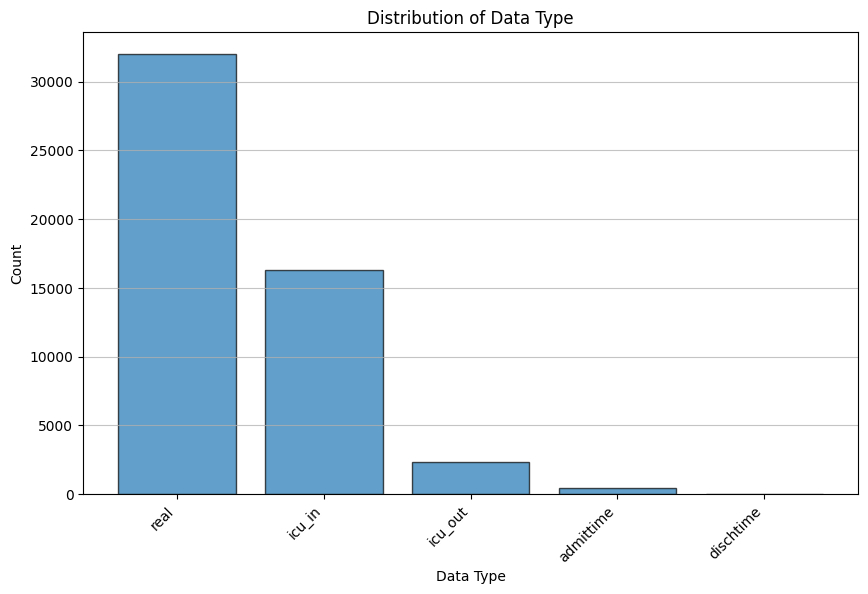

data_type
real         31997
icu_in       16265
icu_out       2329
admittime      467
dischtime        1
Name: count, dtype: int64
Total: 51059


In [32]:
data_type_count = table_intuextu_icu.data_type.value_counts()

plt.figure(figsize=(10, 6))
plt.bar(data_type_count.index, data_type_count.values, edgecolor = 'k',alpha = 0.7)
plt.title('Distribution of Data Type')
plt.xlabel('Data Type')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.75)
plt.xticks(rotation=45, ha='right') 
plt.show()

print(data_type_count)
print(f'Total: {data_type_count.sum()}')

data type 설명
- real     : 원본 삽/발관
- icu_in   : 참고할 unable 삽/발관과 원본 삽/발관이 존재하지 않아 icu 입실 시간으로 채움
- icu_out  : 참고할 unable 삽/발관과 원본 삽/발관이 존재하지 않아 icu 퇴실 시간으로 채움
- dischtime: icu 퇴실 시간이 없는 경우 퇴원 시각으로 채움

#### 3-4 환자 정보 추가

- table_intuextu_icu_patients_paired는 intu/extu 중복 해결한 테이블 (unable_intu_extu 테이블에서 int/ext정보와 함께 intubationtime이 비어있을 경우 admittime을 채워넣고 extubationtime이 비어있을 경우 dischtime을 채워서 작업한 결과)
- 이번에는 unable_intu_extu 테이블에서 환자 정보 컬럼 슬라이싱해서 patients_info 테이블구성
- table_intuextu_icu_patients_paired과 patients_info을 hadm_id를 기준으로 병합하여 reintubation_unable = get_reintubation(table_intuextu_icu_patients)와 같이 Reintubationtime 관련 컬럼추가함수에 들어갈 table_intuextu_icu_patients를 만듦

In [33]:
# 환자 정보
patients_info = adults_icu[['subject_id','stay_id','gender','los','admittime','dischtime','deathtime']]#.drop_duplicates(subset = ["subject_id"])

table_intuextu_icu_patients = pd.merge(patients_info, table_intuextu_icu, on = ['subject_id', 'stay_id'], how = 'inner')
table_intuextu_icu_patients

,subject_id,stay_id,gender,los,admittime,dischtime,deathtime,hadm_id,time,data_type,event_type,extubationcause,flag_dup,time_diff,flag_intudup2_filttime,flag_extudup2_filttime,flag_extu_before_intu,flag_add_extu,flag_add_intu
0,10001884,37510196.0,F,9.171817,2131-01-07 20:39:00,2131-01-20 05:15:00,2131-01-20 05:15:00,26184834,2131-01-11 04:30:00,real,intubation,NaN,False,NaT,False,False,NaN,NaN,NaN
1,10001884,37510196.0,F,9.171817,2131-01-07 20:39:00,2131-01-20 05:15:00,2131-01-20 05:15:00,26184834,2131-01-12 17:40:00,real,extubation,Planned Extubation,False,NaT,False,False,NaN,NaN,NaN
2,10002013,39060235.0,F,1.314352,2160-05-18 07:45:00,2160-05-23 13:30:00,NaT,23581541,2160-05-18 18:00:00,real,extubation,Planned Extubation,False,NaT,False,False,NaN,NaN,NaN
3,10002013,39060235.0,F,1.314352,2160-05-18 07:45:00,2160-05-23 13:30:00,NaT,23581541,2160-05-18 10:00:53,icu_in,intubation,NaN,False,NaT,False,False,False,False,False
4,10002428,35479615.0,F,10.977222,2156-05-11 14:49:00,2156-05-22 14:16:00,NaT,23473524,2156-05-20 10:45:00,real,extubation,Planned Extubation,False,NaT,False,False,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51054,19999442,32336619.0,M,6.950370,2148-11-19 10:00:00,2148-12-04 16:25:00,NaT,26785317,2148-11-20 14:15:00,real,extubation,Planned Extubation,False,NaT,False,False,NaN,NaN,NaN
51055,19999840,38978960.0,M,5.297766,2164-09-10 13:47:00,2164-09-17 13:42:00,2164-09-17 13:42:00,21033226,2164-09-12 09:40:00,real,intubation,NaN,False,NaT,False,False,NaN,NaN,NaN
51056,19999840,38978960.0,M,5.297766,2164-09-10 13:47:00,2164-09-17 13:42:00,2164-09-17 13:42:00,21033226,2164-09-17 16:35:15,icu_out,extubation,NaN,False,NaT,False,False,False,False,False
51057,19999987,36195440.0,F,1.937847,2145-11-02 21:38:00,2145-11-11 12:57:00,NaT,23865745,2145-11-03 20:40:00,real,extubation,Planned Extubation,False,NaT,False,False,NaN,NaN,NaN


#### 3-5 flag 제거
- flag_extu_before_intu: extu가 intu보다 이전에 나온 경우
- flag_intudup2_filttime: intu가 연달아 나올 때, data_type이 서로 다르고(unable intu 다음에 원본 intu | 원본 intu 다음에 unable intu) time_diff가 평균 시간보다 작은 경우
- flag_extudup2_filttime: extu가 연달아 나올 때, data_type이 서로 다르고(unable extu 다음에 원본 extu | 원본 extu 다음에 unable extu) time_diff가 평균 시간보다 작은 경우

In [34]:
table_flag = table_intuextu_icu_patients.copy()

In [ ]:
table = table_flag.copy()
table = table[~(table.flag_intudup2_filttime)]
table # 50660     

,subject_id,stay_id,gender,los,admittime,dischtime,deathtime,hadm_id,time,data_type,event_type,extubationcause,flag_dup,time_diff,flag_intudup2_filttime,flag_extudup2_filttime,flag_extu_before_intu,flag_add_extu,flag_add_intu
0,10001884,37510196.0,F,9.171817,2131-01-07 20:39:00,2131-01-20 05:15:00,2131-01-20 05:15:00,26184834,2131-01-11 04:30:00,real,intubation,NaN,False,NaT,False,False,NaN,NaN,NaN
1,10001884,37510196.0,F,9.171817,2131-01-07 20:39:00,2131-01-20 05:15:00,2131-01-20 05:15:00,26184834,2131-01-12 17:40:00,real,extubation,Planned Extubation,False,NaT,False,False,NaN,NaN,NaN
2,10002013,39060235.0,F,1.314352,2160-05-18 07:45:00,2160-05-23 13:30:00,NaT,23581541,2160-05-18 18:00:00,real,extubation,Planned Extubation,False,NaT,False,False,NaN,NaN,NaN
3,10002013,39060235.0,F,1.314352,2160-05-18 07:45:00,2160-05-23 13:30:00,NaT,23581541,2160-05-18 10:00:53,icu_in,intubation,NaN,False,NaT,False,False,False,False,False
4,10002428,35479615.0,F,10.977222,2156-05-11 14:49:00,2156-05-22 14:16:00,NaT,23473524,2156-05-20 10:45:00,real,extubation,Planned Extubation,False,NaT,False,False,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51054,19999442,32336619.0,M,6.950370,2148-11-19 10:00:00,2148-12-04 16:25:00,NaT,26785317,2148-11-20 14:15:00,real,extubation,Planned Extubation,False,NaT,False,False,NaN,NaN,NaN
51055,19999840,38978960.0,M,5.297766,2164-09-10 13:47:00,2164-09-17 13:42:00,2164-09-17 13:42:00,21033226,2164-09-12 09:40:00,real,intubation,NaN,False,NaT,False,False,NaN,NaN,NaN
51056,19999840,38978960.0,M,5.297766,2164-09-10 13:47:00,2164-09-17 13:42:00,2164-09-17 13:42:00,21033226,2164-09-17 16:35:15,icu_out,extubation,NaN,False,NaT,False,False,False,False,False
51057,19999987,36195440.0,F,1.937847,2145-11-02 21:38:00,2145-11-11 12:57:00,NaT,23865745,2145-11-03 20:40:00,real,extubation,Planned Extubation,False,NaT,False,False,NaN,NaN,NaN


In [ ]:
table = table_flag.copy()
table = table[~(table.flag_intudup2_filttime)]
table = table[~(table.flag_extudup2_filttime)]
table # 49556       

,subject_id,stay_id,gender,los,admittime,dischtime,deathtime,hadm_id,time,data_type,event_type,extubationcause,flag_dup,time_diff,flag_intudup2_filttime,flag_extudup2_filttime,flag_extu_before_intu,flag_add_extu,flag_add_intu
0,10001884,37510196.0,F,9.171817,2131-01-07 20:39:00,2131-01-20 05:15:00,2131-01-20 05:15:00,26184834,2131-01-11 04:30:00,real,intubation,NaN,False,NaT,False,False,NaN,NaN,NaN
1,10001884,37510196.0,F,9.171817,2131-01-07 20:39:00,2131-01-20 05:15:00,2131-01-20 05:15:00,26184834,2131-01-12 17:40:00,real,extubation,Planned Extubation,False,NaT,False,False,NaN,NaN,NaN
2,10002013,39060235.0,F,1.314352,2160-05-18 07:45:00,2160-05-23 13:30:00,NaT,23581541,2160-05-18 18:00:00,real,extubation,Planned Extubation,False,NaT,False,False,NaN,NaN,NaN
3,10002013,39060235.0,F,1.314352,2160-05-18 07:45:00,2160-05-23 13:30:00,NaT,23581541,2160-05-18 10:00:53,icu_in,intubation,NaN,False,NaT,False,False,False,False,False
4,10002428,35479615.0,F,10.977222,2156-05-11 14:49:00,2156-05-22 14:16:00,NaT,23473524,2156-05-20 10:45:00,real,extubation,Planned Extubation,False,NaT,False,False,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51054,19999442,32336619.0,M,6.950370,2148-11-19 10:00:00,2148-12-04 16:25:00,NaT,26785317,2148-11-20 14:15:00,real,extubation,Planned Extubation,False,NaT,False,False,NaN,NaN,NaN
51055,19999840,38978960.0,M,5.297766,2164-09-10 13:47:00,2164-09-17 13:42:00,2164-09-17 13:42:00,21033226,2164-09-12 09:40:00,real,intubation,NaN,False,NaT,False,False,NaN,NaN,NaN
51056,19999840,38978960.0,M,5.297766,2164-09-10 13:47:00,2164-09-17 13:42:00,2164-09-17 13:42:00,21033226,2164-09-17 16:35:15,icu_out,extubation,NaN,False,NaT,False,False,False,False,False
51057,19999987,36195440.0,F,1.937847,2145-11-02 21:38:00,2145-11-11 12:57:00,NaT,23865745,2145-11-03 20:40:00,real,extubation,Planned Extubation,False,NaT,False,False,NaN,NaN,NaN


In [37]:
# stay_id별 intu, extu의 개수가 다른지 확인하기 위한 코드
df = table.groupby('stay_id').event_type.value_counts().reset_index()
df.loc[:, 'extu_count'] = df.groupby('stay_id')['count'].shift(-1)

df[(df['extu_count'].notna()) & (df['count'] != df['extu_count'])] # 아무것도 안 나와야 함

,stay_id,event_type,count,extu_count


In [38]:
table_check = table.copy()
table_check = align.sort_intuextu(table_check) # 정렬 (삽/발관 시간이 같은 경우 intubation이 먼저 나옴)
table_check = align.duplicates_row_flag(table_check) # 연속해서 intubation이 있거나 extubation이 연속해서 있는 경우 flag_dup 생성

table_check[table_check.flag_dup] # 최종 점검, 아무것도 안 나와야 함

,subject_id,stay_id,gender,los,admittime,dischtime,deathtime,hadm_id,time,data_type,event_type,extubationcause,flag_dup,time_diff,flag_intudup2_filttime,flag_extudup2_filttime,flag_extu_before_intu,flag_add_extu,flag_add_intu


#### 3-6 pairing 및 seq 부여

event_type이 intu인 경우 테이블을 intubation_table\
event_type이 extu인 경우 테이블을 extubation_table

- intubation_table, extubation_table을 id들을 기준으로 intu 이후의 시간과 가장 가까운 extu시간을 열 방향으로 배열

In [39]:
table_flag_delete = table.copy()

In [40]:
# 행 방향으로 존재하던 event를 subject_id, hadm_id, stay_id 기준으로 intu, extu를 열 방향으로 배열
table_tmp = table_flag_delete[:].copy()

# intubation, extubation 페어링
intubation_table = table_tmp[table_tmp.event_type == 'intubation'].rename(columns={'time':'intubationtime'})
extubation_table = table_tmp[table_tmp.event_type == 'extubation'].rename(columns = {'time':'extubationtime'})

intubation_table['intubationtime'] = pd.to_datetime(intubation_table['intubationtime'])
extubation_table['extubationtime'] = pd.to_datetime(extubation_table['extubationtime'])
                                
# 테이블 시간 정렬
intubation_df = intubation_table.sort_values('intubationtime')
extubation_df = extubation_table.sort_values('extubationtime')

paired_df = pd.merge_asof(
    intubation_df[['subject_id', 'stay_id', 'gender', 'los', 'admittime', 'dischtime',
       'deathtime', 'hadm_id', 'intubationtime', 'event_type', 'flag_dup',
       'time_diff', 'flag_intudup2_filttime']],
       
    extubation_df[['hadm_id', 'subject_id', 'stay_id', 'extubationtime', 'event_type', 'extubationcause', 'flag_dup',
       'time_diff','flag_extudup2_filttime']],
       
    left_on='intubationtime',
    right_on='extubationtime',
    by=['subject_id', 'hadm_id', 'stay_id'],  # 같은 subject_id, hadm_id, stay_id 기준으로
    direction='forward'  # intubation 이후의 가장 가까운 extubation 시간과 페어링
)

# 테이블 페어링 후 복사본 생성
table_intuextu_icu_patients_paired = paired_df.copy()

# 열 이름 변경
table_intuextu_icu_patients_paired.rename(columns = {'data_type_x':'intu_data', 'data_type_y':'extu_data', 'extubationcause_y':'extubationcause'}, inplace = True)
table_intuextu_icu_patients_paired.drop(columns = ['event_type_x','event_type_y'], inplace = True)
for word in table_intuextu_icu_patients_paired.columns:
    if word.split('_')[-1] == 'x':
        replace_word = 'int_' + '_'.join(word.split('_')[:-1])
        table_intuextu_icu_patients_paired.rename(columns = {word:replace_word}, inplace = True)

    elif word.split('_')[-1] == 'y':
        replace_word = ('ext_' + '_'.join(word.split('_')[:-1]))
        table_intuextu_icu_patients_paired.rename(columns = {word:replace_word}, inplace = True)
    
print(table_intuextu_icu_patients_paired.columns)

Index(['subject_id', 'stay_id', 'gender', 'los', 'admittime', 'dischtime',
       'deathtime', 'hadm_id', 'intubationtime', 'int_flag_dup',
       'int_time_diff', 'flag_intudup2_filttime', 'extubationtime',
       'extubationcause', 'ext_flag_dup', 'ext_time_diff',
       'flag_extudup2_filttime'],
      dtype='object')


In [41]:
print(f'before_withflag_row_count: {before_withflag.shape[0]}') 
print(f'subjectlist1_row_count: {table_intuextu_icu_patients_paired.shape[0]}')

before_withflag_row_count: 27263
subjectlist1_row_count: 24778


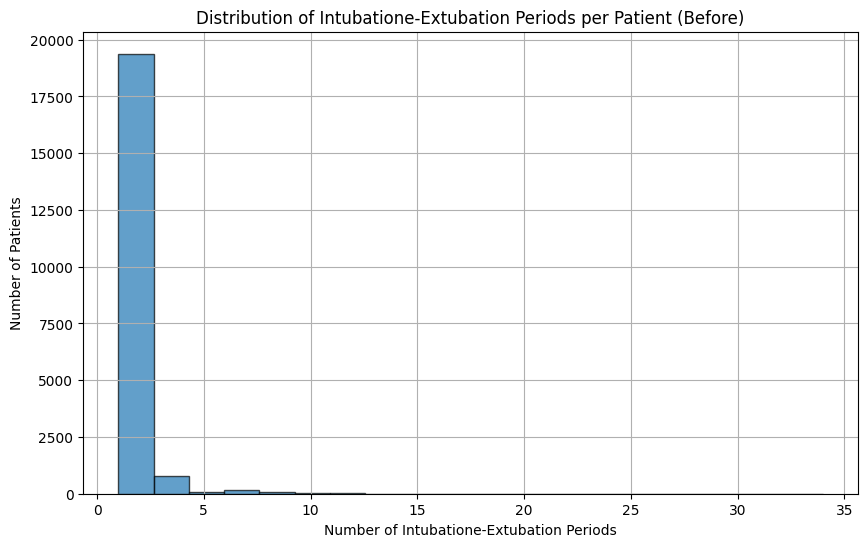

Before
count    20523.000000
mean         1.328412
std          1.136663
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         34.000000
Name: count, dtype: float64


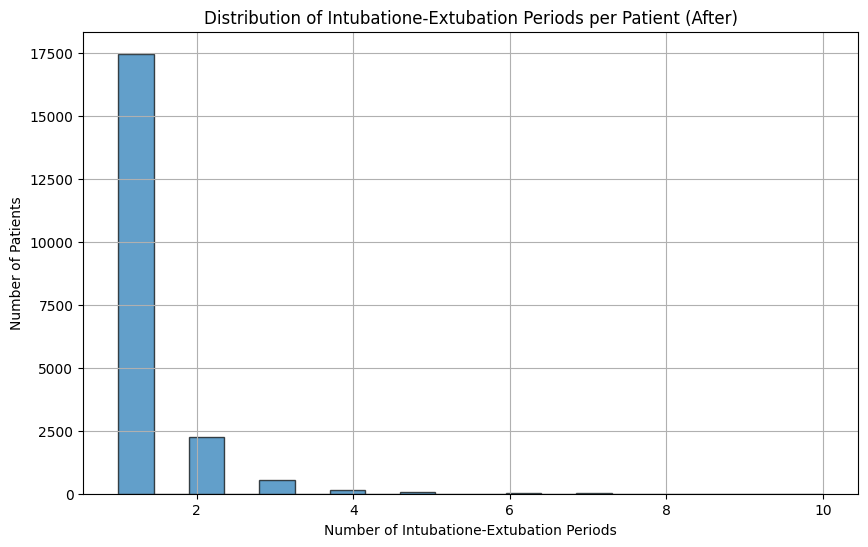

After
count    20523.000000
mean         1.207328
std          0.598329
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         10.000000
Name: count, dtype: float64


In [42]:
# 환자별 삽/발관 횟수 분포

# 환자별 Intubatione-Extubaion(Before) 횟수 분포
patient_before_withflag_counts = before_withflag.subject_id.value_counts()
plt.figure(figsize=(10, 6))
patient_before_withflag_counts.hist(bins=20, edgecolor = 'k', alpha = 0.7)
plt.title('Distribution of Intubatione-Extubation Periods per Patient (Before)')
plt.xlabel('Number of Intubatione-Extubation Periods')
plt.ylabel('Number of Patients')
plt.show()

print('Before')
print(patient_before_withflag_counts.describe())


# 환자별 Intubatione-Extubaion(After) 횟수 분포
patient_table_intuextu_icu_patients_paired_counts = table_intuextu_icu_patients_paired.subject_id.value_counts()
plt.figure(figsize=(10, 6))
patient_table_intuextu_icu_patients_paired_counts.hist(bins=20, edgecolor = 'k', alpha = 0.7)
plt.title('Distribution of Intubatione-Extubation Periods per Patient (After)')
plt.xlabel('Number of Intubatione-Extubation Periods')
plt.ylabel('Number of Patients')
plt.show()

print('After')
print(patient_table_intuextu_icu_patients_paired_counts.describe())

## - Reintubationtime  관련 변수들 계산, 데이터 정리
- create_reintubation_columns(group, ignore_exist=False):
    * reint_marker, mvtime, reintubation_eventtime 및 reintubationtime 칼럼을 생성합니다. 
    * reintubation_eventtime는 timestamp 형태로 (nan), reintubationtime는 float 형태로 초기화합니다.
- get_mvtime(group):
    * 현재 행의 intubationtime과 extubationtime의 시간 차이를 구합니다 (분 단위; float).
    * 두 값 중 하나라도 null이면, mvtime은 null로 설정됩니다.
    
- carryover_next_intubationtime(group):
    * 다음행의 intubationtime을 현재행의 reintubation_eventtime 칼럼으로 가져옵니다.
   
- get_reint_marker(group):
    * 이 함수는 그룹 내의 행이 1개를 초과하는 경우,모든 행의 'reint_marker' 칼럼을 True로 설정합니다.
    * 이는 재삽관이 있는 그룹을 표시하는 데 사용됩니다.
    
- get_reintubationtime(group):
    * 'reintubation_eventtime' (다음 intubationtime)과 현재의 'extubationtime'의 시간차를 구합니다 (분 단위; float).
    

In [43]:
def get_reintubation(df):
    start_time = time.time()   # 소요시간 계산
    grouped_df = df.groupby(['hadm_id', 'stay_id'])

    df_list = []
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)
            
        for _, patient_df in tqdm(grouped_df, desc="Fetching reintubation data..."):

            patient_df = rnt.create_reintubation_columns(patient_df)   # reintubationtime 칼럼 초기화 (reint_marker, mvtime, 다음 발관 시간, 재삽관 시간)
            patient_df = rnt.get_mvtime(patient_df)   # 삽관시간과 발관시간의 차이 계산
            patient_df = rnt.carryover_next_intubationtime(patient_df)   # 다음 삽관시간 가져오기
            patient_df = rnt.get_reint_marker(patient_df)   # 환자별로 재삽관이 존재하는지 마킹
            patient_df = rnt.get_reintubationtime(patient_df)   # 재삽관 시간 계산하기
            
            df_list.append(patient_df)

        # 환자별 데이터 하나의 데이터프레임으로 합치기
        reintubation_df = pd.concat(df_list)
        reintubation_df = reintubation_df.reset_index(drop=True)

        # 각 그룹별로 시퀀스 넘버링 해주기
        reintubation_df['seq_num'] = reintubation_df.groupby(['hadm_id', 'stay_id']).cumcount() + 1
    
    print("--- RUNTIME: %.2f seconds ---" % round(time.time() - start_time, 2))
        
    return reintubation_df

In [44]:
table_intuextu_icu_patients_paired_reintu = get_reintubation(table_intuextu_icu_patients_paired)
table_intuextu_icu_patients_paired_reintu.info()

Fetching reintubation data...: 100%|██████████| 22581/22581 [00:42<00:00, 526.24it/s]


--- RUNTIME: 59.95 seconds ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24778 entries, 0 to 24777
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype          
---  ------                  --------------  -----          
 0   subject_id              24778 non-null  int64          
 1   stay_id                 24778 non-null  float64        
 2   gender                  24778 non-null  object         
 3   los                     24778 non-null  float64        
 4   admittime               24778 non-null  datetime64[ns] 
 5   dischtime               24778 non-null  datetime64[ns] 
 6   deathtime               4131 non-null   datetime64[ns] 
 7   hadm_id                 24778 non-null  int64          
 8   intubationtime          24778 non-null  datetime64[ns] 
 9   int_flag_dup            24778 non-null  bool           
 10  int_time_diff           0 non-null      timedelta64[ns]
 11  flag_intudup2_filttime  24778 non-null  bool           
 12  e

In [45]:
table_intuextu_icu_patients_paired_reintu.to_csv('./data/sub1_table_intuextu_icu_patients_paired_reintu.csv')

- 환자군 분류 (ext failure, non-failure, etc.)

분류 코드
11 재삽관 없이 발관후 48시간 넘어 퇴원 | nonfailure

121 재삽관 없이 발관후 48시간 이내 사망 X | nonfailure

1221 재삽관 없이 발관후 24시간 이내 사망 | death

1222 재삽관 없이 발관후 24~48시간 이내 사망 | death

211 48시간 이내 재삽관 | failure

212 48시간 너머 재삽관 | nonfailure

221 최종 발관 이후 48시간 넘어 퇴원 | nonfailure

2221 최종 발관 이후 48시간 이내 사망 X | nonfailure

22221 최종 발관 이후 24시간 이내 사망 | death

22222 최종 발관 이후 24~48시간 이내 사망 | death

999 (null case)현발관-다음발관이 48시간 이내 | Failure

998 (null case)현삽관-다음삽관이 48시간 이내 | Failure

9999 (null case) non-failure 판단 불가 | 제거

In [ ]:
# 데이터 임포트
table_intuextu_icu_patients_paired_reintu = pd.read_csv('./data/sub1_table_intuextu_icu_patients_paired_reintu.csv', index_col=0, \
                               parse_dates=['intubationtime', 'extubationtime', \
                                            'admittime', 'dischtime', 'deathtime'])

print(table_intuextu_icu_patients_paired_reintu.shape)   # (24778, 22)

(24778, 22)


In [47]:
def categorize_patients(df):
    # 분류 코드 기준
    categories = {
        "nonfailure": [11, 121, 212, 221, 2221],
        "failure": [211, 999, 998],
        "death": [1221, 1222, 22221, 22222]
    }

    start_time = time.time()   # 소요시간 계산

    # df = imp.init_marker(df)   # 'marker' 칼럼 생성 (결측치 대체 로그가 저장됨)
    grouped_df = df.groupby(['subject_id', 'hadm_id', 'stay_id'])

    df_list = []
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)
            
        for _, patient_df in tqdm(grouped_df, desc="Categorizing extubation failure vs non-failure..."):

            patient_df = cls.init_class_columns(patient_df)   # flag_mvtime_state, ext_to_death, ext_to_disch, disch_to_death, class_code 칼럼 초기화
            patient_df = cls.fill_class_columns(patient_df)   # 초기화한 칼럼 값(flag_mvtime_state, ext_to_death, ext_to_disch, disch_to_death) 계산해서 채워주기
            patient_df = cls.classify_patients(patient_df)   # 행별로 케이스 분류해서 class_code 입력해주는 코드
            patient_df = cls.categorize_code(patient_df, categories)   # class_code 기반으로 extubation failure, non-failure 분류해주는 코드
            df_list.append(patient_df)

        # 환자별 데이터 하나의 데이터프레임으로 합치기
        subjects_df = pd.concat(df_list)
        subjects_df = subjects_df.reset_index(drop=True)

    
    print("--- RUNTIME: %.2f seconds ---" % round(time.time() - start_time, 2))
        
    return subjects_df

In [ ]:
intubation_extubation_before_paired = categorize_patients(table_intuextu_icu_patients_paired_reintu)

print(f'Processed subjectlist2: {intubation_extubation_before_paired.shape}')   # (24778, 29)

intubation_extubation_before_paired.columns

Categorizing extubation failure vs non-failure...: 100%|██████████| 22581/22581 [02:12<00:00, 170.75it/s]


--- RUNTIME: 144.76 seconds ---
Processed subjectlist2: (24778, 29)


Index(['subject_id', 'stay_id', 'gender', 'los', 'admittime', 'dischtime',
       'deathtime', 'hadm_id', 'intubationtime', 'int_flag_dup',
       'int_time_diff', 'flag_intudup2_filttime', 'extubationtime',
       'extubationcause', 'ext_flag_dup', 'ext_time_diff',
       'flag_extudup2_filttime', 'reint_marker', 'mvtime',
       'reintubation_eventtime', 'reintubationtime', 'seq_num', 'mvtime_state',
       'final_event', 'ext_to_death', 'ext_to_disch', 'disch_to_death',
       'class_code', 'class'],
      dtype='object')

In [49]:
table_intuextu_icu_patients_paired_reintu_category = intubation_extubation_before_paired.copy()

In [50]:
intubation_extubation_before_paired = table_intuextu_icu_patients_paired_reintu_category.copy()

In [51]:
intubation_extubation_before_paired.head()

,subject_id,stay_id,gender,los,admittime,dischtime,deathtime,hadm_id,intubationtime,int_flag_dup,...,reintubation_eventtime,reintubationtime,seq_num,mvtime_state,final_event,ext_to_death,ext_to_disch,disch_to_death,class_code,class
0,10001884,37510196.0,F,9.171817,2131-01-07 20:39:00,2131-01-20 05:15:00,2131-01-20 05:15:00,26184834,2131-01-11 04:30:00,False,...,NaN,NaN,1,False,True,10775.0,10775.0,0.0,11,nonfailure
1,10002013,39060235.0,F,1.314352,2160-05-18 07:45:00,2160-05-23 13:30:00,NaT,23581541,2160-05-18 10:00:53,False,...,NaN,NaN,1,True,True,NaN,6930.0,NaN,11,nonfailure
2,10002428,35479615.0,F,10.977222,2156-05-11 14:49:00,2156-05-22 14:16:00,NaT,23473524,2156-05-11 14:49:34,False,...,NaN,NaN,1,False,True,NaN,3091.0,NaN,11,nonfailure
3,10002428,38875437.0,F,7.032894,2156-04-12 14:16:00,2156-04-29 16:26:00,NaT,28662225,2156-04-19 18:11:19,False,...,NaN,NaN,1,False,True,NaN,10036.0,NaN,11,nonfailure
4,10002760,31831386.0,M,1.045868,2141-04-20 07:15:00,2141-04-24 13:31:00,NaT,28094813,2141-04-20 13:20:46,False,...,NaN,NaN,1,True,True,NaN,4651.0,NaN,11,nonfailure


In [52]:
# # real intu, real extu 시간이 같은 경우
# intubation_extubation_before_paired[(intubation_extubation_before_paired.intubationtime == intubation_extubation_before_paired.extubationtime) & (intubation_extubation_before_paired.intu_data== 'unable') & (intubation_extubation_before_paired.intu_data == intubation_extubation_before_paired.extu_data)] # 11

In [53]:
# 최종 데이터셋 flag적용 비논리적 데이터 삭제 

intubation_extubation_before_paired = intubation_extubation_before_paired[((intubation_extubation_before_paired.mvtime.isna()) | (intubation_extubation_before_paired.mvtime >= 0)) &\
              ((intubation_extubation_before_paired.reintubationtime.isna()) | (intubation_extubation_before_paired.reintubationtime >= 0))] # 0

In [54]:
# indices_to_drop = intubation_extubation_before_withflag[
#     intubation_extubation_before_withflag['intubationtime'] > intubation_extubation_before_withflag['extubationtime']
# ].index

# # 해당 인덱스를 사용하여 데이터프레임에서 행 삭제
# intubation_extubation_before_withflag = intubation_extubation_before_withflag.drop(indices_to_drop)
# intubation_extubation_before_withflag

<Figure size 2000x1000 with 0 Axes>

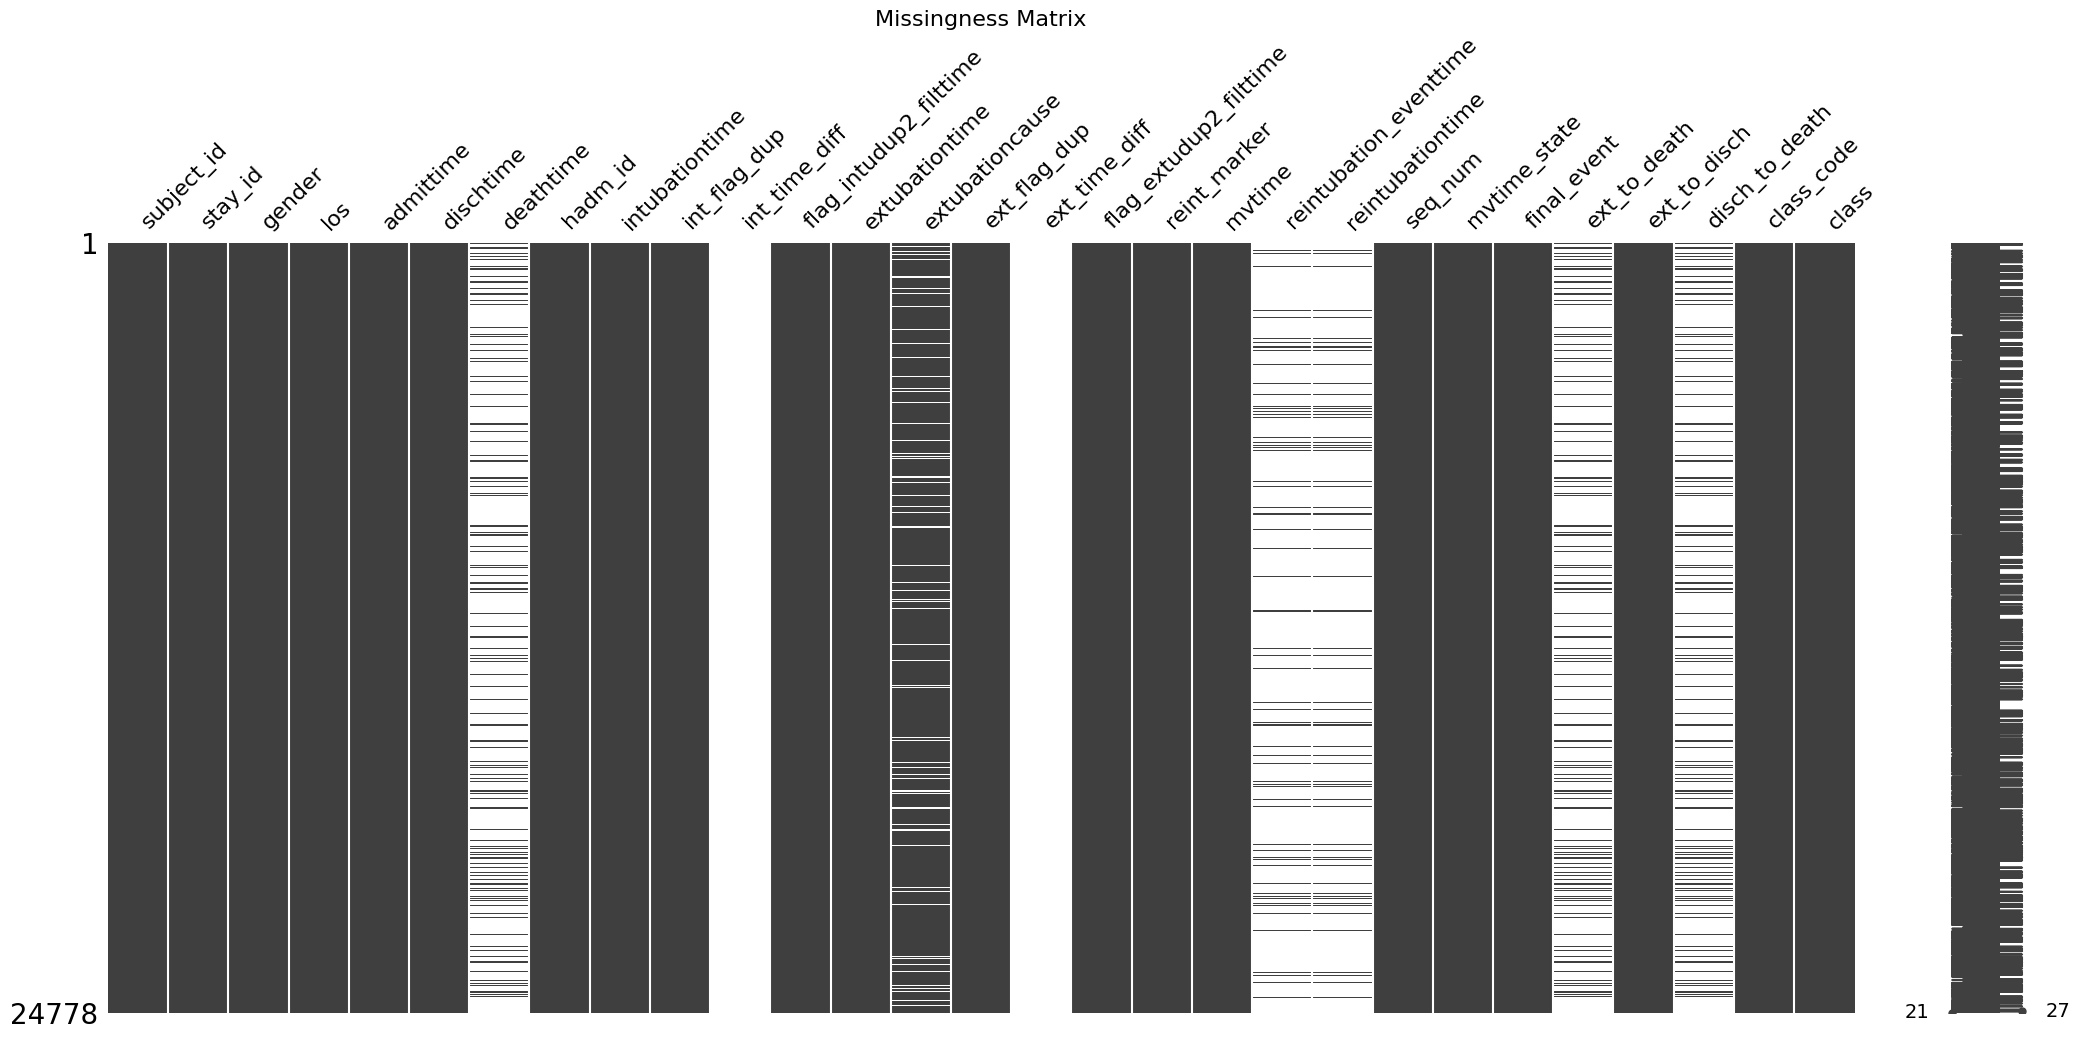

In [55]:
# 결측치 행렬 생성
plt.figure(figsize=(20, 10))
msno.matrix(intubation_extubation_before_paired)
plt.title('Missingness Matrix', fontsize=16)
plt.show()

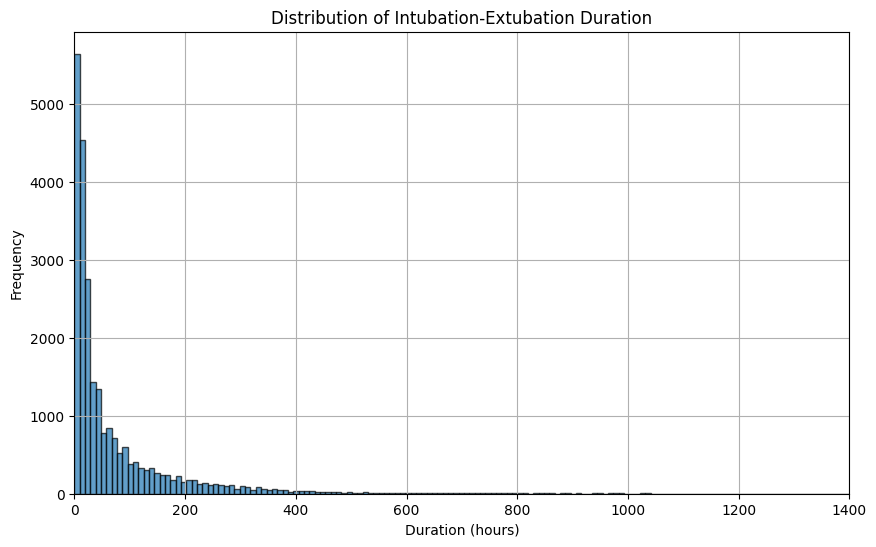

count    24778.000000
mean        78.952291
std        149.509505
min          0.000000
25%         10.538889
50%         26.266667
75%         87.289375
max       4819.733333
Name: duration, dtype: float64

In [56]:
# 삽관 기간의 분포 시각화
intubation_extubation_before_paired.loc[:,'duration'] = (intubation_extubation_before_paired.extubationtime - intubation_extubation_before_paired.intubationtime).dt.total_seconds() / 3600

plt.figure(figsize=(10, 6))
intubation_extubation_before_paired.duration.hist(bins = 500, edgecolor='k', alpha=0.7)
plt.title('Distribution of Intubation-Extubation Duration')
plt.xlabel('Duration (hours)')
plt.ylabel('Frequency')
plt.xlim([0,1400])
plt.show()

intubation_extubation_before_paired.duration.describe()

In [57]:
# 데이터 저장
sub1list_unable = intubation_extubation_before_paired >> select('subject_id','hadm_id',\
                                  'stay_id', 'admittime', 'dischtime')
sub1list_unable = sub1list_unable.drop_duplicates(subset='stay_id')   # remove dup

intubation_extubation_before_paired.to_csv('./data/intubation_extubation_before_paired.csv')